In [1]:
from pyspark.sql import SQLContext
import json
from IPython import display
from IPython.core.display import HTML
import pandas
import time

In [2]:
'''create GSR dataframe for a time range'''

startTimeStr = "2015-06-01T00:00:00Z"
endTimeStr = "2016-03-31T23:59:59Z"

gsrDf = SQLContext(sc).read.load(format = "au.com.d2dcrc.carbon.spark.gsr", startTime = startTimeStr, endTime = endTimeStr)
gsrDf.printSchema()
print(gsrDf.count())
#gsrDf.toPandas()


root
 |-- key:eventDate: timestamp (nullable = false)
 |-- key:id: long (nullable = false)
 |-- authorId: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampRevision: timestamp (nullable = true)
 |-- widespreadEventId: long (nullable = true)
 |-- eventType: string (nullable = true)
 |-- populationGroup: string (nullable = true)
 |-- country: string (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- earliestReportedDate: timestamp (nullable = true)
 |-- crowdSize: string (nullable = true)
 |-- isViolent: boolean (nullable = true)
 |-- newsSourceName: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- englishHeadline: string (nullable = true)
 |-- eventDescription: string (nullable = true)
 |-- firstReportedLink: string (nullable = true)
 |-- otherLinks: string (nullable = true)
 |-- comment: string (nullable = true)

3445


In [3]:
#someGSR = gsrDf.select("key:eventDate", "state", "headline", "eventDescription", "firstReportedLink", "eventType", 
#                       "populationGroup", "country", "authorId", "widespreadEventId")
#.filter("country = \"Australia\" and state = \"NSW\"").orderBy("key:eventDate").limit(100)

#groupedGSR = gsrDf.groupBy("city", "eventType", "populationGroup").count()
#groupedGSR.toPandas()

In [4]:
#join = groupedGSR.join(gsrDf, ["city", "eventType", "populationGroup"], "left_outer").select("city", "eventType", "populationGroup", "count", "key:eventDate")
#join.toPandas()

In [3]:
'''get dataframe with schema ((location,eventType,populationGroup),date)'''

#row.asDict()['key:eventDate'] has type datetime.datetime
#row.asDict()['key:eventDate'].strftime("%Y-%m-%d")

#mappedDf = gsrDf.rdd.map(lambda row : ((row.city, row.eventType, row.populationGroup), ((row.asDict()['key:eventDate'].strftime("%Y-%m-%d")))))
mappedDf = gsrDf.rdd.map(lambda row : ((str(row.country)+'/'+str(row.state)+'/'+str(row.city), row.eventType, row.populationGroup), ((row.asDict()['key:eventDate'].date()))))

print(mappedDf.count())
mappedDf.take(5)

3445


[(('Malaysia/Negeri Sembilan/Seremban',
   'Other Government and Political Issues',
   'Labor'),
  datetime.date(2015, 6, 11)),
 (('Fiji/Fiji/Labasa', 'Other Social Disruption', 'General Population'),
  datetime.date(2015, 6, 13)),
 (('Australia/WA/Swan', 'Other Social Disruption', 'General Population'),
  datetime.date(2015, 6, 13)),
 (('Indonesia/West Java/Depok', 'Other Social Disruption', 'Religious'),
  datetime.date(2015, 6, 14)),
 (('Australia/VIC/Melbourne', 'Employment and Wages', 'Labor'),
  datetime.date(2015, 6, 15))]

In [4]:
'''aggregate tuples with the same (location,eventType,populationGroup)'''

#grouped = mappedDf.groupByKey().map(lambda x: (x[0],list(x[1]))).filter(lambda x: len(x[1])>=3)
#grouped = mappedDf.groupByKey().mapValues(list)
groupedDf = mappedDf.aggregateByKey(list(), lambda lst,val: lst+[val], lambda lst1,lst2: lst1+lst2).filter(lambda x: len(x[1])>=4)
print(groupedDf.count())
groupedList = groupedDf.collect()
groupedList[0:3]

150


[(('Indonesia/West Java/Bandung', 'Employment and Wages', 'Labour'),
  [datetime.date(2015, 11, 24),
   datetime.date(2015, 8, 11),
   datetime.date(2015, 8, 5),
   datetime.date(2015, 9, 1)]),
 (('Australia/SA/None',
   'Other Government and Political Issues',
   'General Population'),
  [datetime.date(2015, 8, 9),
   datetime.date(2015, 12, 9),
   datetime.date(2015, 8, 15),
   datetime.date(2015, 7, 25),
   datetime.date(2015, 11, 23)]),
 (('Indonesia/Bali/Denpasar', 'Employment and Wages', 'labour'),
  [datetime.date(2015, 11, 30),
   datetime.date(2015, 11, 19),
   datetime.date(2015, 11, 19),
   datetime.date(2015, 12, 3)])]

In [5]:
'''plot functions'''

%matplotlib inline
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.dates import DateFormatter, DayLocator, MonthLocator, WeekdayLocator

#this fuction takes a dictionary and plots key value pairs
def plot_bargraph(d, rot='vertical'):
    plt.bar(range(len(d)), d.values(), align="center")
    plt.xticks(range(len(d)), list(d.keys()),rotation=rot)
    plt.show()


#d is a dict, scale can be either "daily", "weekly", or "monthly"
def plot_pattern_timeline(d, scale='monthly', style='bo-'):
    #below two lines used to draw multiple plots
    #fig, ax = plt.subplots(2,1, figsize=(15,3))
    #plt.axes(ax[0])
    fig, ax = plt.subplots(1,1, figsize=(15,3))
    plt.axes(ax)
    items = sorted(d.items())
    #print(items)
    dates = []
    values = []
    for item in items:
        dates.append(item[0])
        values.append(item[1])
    #print(dates, values)
    plt.plot(dates, values, style)
    dateFormatStr = "%d-%b" # default format
    if scale=='monthly':
        locator = MonthLocator()
        dateFormatStr = "%b"
    elif scale=='weekly':
        locator = WeekdayLocator()
    elif scale=='daily':
        locator = DayLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(DateFormatter(dateFormatStr))
    plt.show()
    
    
#d is a dict, scale can be either "daily", "weekly", or "monthly"
def plot_pattern_timeline_multilines(dofd, scale='monthly'):
    #below two lines used to draw multiple plots
    #fig, ax = plt.subplots(2,1, figsize=(15,3))
    #plt.axes(ax[0])
    fig, ax = plt.subplots(1,1, figsize=(15,3))
    plt.axes(ax)
    listOfDV = []
    for key in dofd:
        d = dofd[key]   
        items = sorted(d.items())
        #print(items)
        dates = []
        values = []
        for item in items:
            dates.append(item[0])
            values.append(item[1])
        #print(dates, values)
        listOfDV.append((dates,values,key))
    if len(listOfDV)==1:
        print(listOfDV[0][2], 'in blue')
        plt.plot(listOfDV[0][0], listOfDV[0][1], 'bo-')
    elif len(listOfDV)==2:
        print(listOfDV[0][2], 'in blue,', listOfDV[1][2], 'in red')
        plt.plot(listOfDV[0][0], listOfDV[0][1], 'bo-', listOfDV[1][0], listOfDV[1][1], 'ro-')
    elif len(listOfDV)==3:
        print(listOfDV[0][2], 'in blue,', listOfDV[1][2], 'in red,', listOfDV[2][2], 'in green')
        plt.plot(listOfDV[0][0], listOfDV[0][1], 'bo-', listOfDV[1][0], listOfDV[1][1], 'ro-', listOfDV[2][0], listOfDV[2][1], 'go-')
    elif len(listOfDV)==4:
        print(listOfDV[0][2], 'in blue,', listOfDV[1][2], 'in red,', listOfDV[2][2], 'in green,', listOfDV[3][2], 'in cyan')
        plt.plot(listOfDV[0][0], listOfDV[0][1], 'bo-', listOfDV[1][0], listOfDV[1][1], 'ro-', listOfDV[2][0], listOfDV[2][1], 'go-', listOfDV[3][0], listOfDV[3][1], 'co-')
    elif len(listOfDV)>=5:
        print(listOfDV[0][2], 'in blue,', listOfDV[1][2], 'in red,', listOfDV[2][2], 'in green,', listOfDV[3][2], 'in cyan,', listOfDV[4][2], 'in magenta')
        plt.plot(listOfDV[0][0], listOfDV[0][1], 'bo-', listOfDV[1][0], listOfDV[1][1], 'ro-', listOfDV[2][0], listOfDV[2][1], 'go-', listOfDV[3][0], listOfDV[3][1], 'co-', listOfDV[4][0], listOfDV[4][1], 'mo-') 
    dateFormatStr = "%d-%b" # default format
    if scale=='monthly':
        locator = MonthLocator()
        dateFormatStr = "%b"
    elif scale=='weekly':
        locator = WeekdayLocator()
    elif scale=='daily':
        locator = DayLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(DateFormatter(dateFormatStr))
    plt.show()

In [8]:
'''
from collections import Counter
for tup in groupedList:
    print(tup)
    counter = Counter(tup[1])
    print(counter)
    lt = sorted(counter.items())
    print(lt)
    plot_bargraph(dict(lt))
'''

'\nfrom collections import Counter\nfor tup in groupedList:\n    print(tup)\n    counter = Counter(tup[1])\n    print(counter)\n    lt = sorted(counter.items())\n    print(lt)\n    plot_bargraph(dict(lt))\n'

('Indonesia/West Java/Bandung', 'Employment and Wages', 'Labour')
Counter({datetime.date(2015, 8, 5): 1, datetime.date(2015, 8, 11): 1, datetime.date(2015, 11, 24): 1, datetime.date(2015, 9, 1): 1})


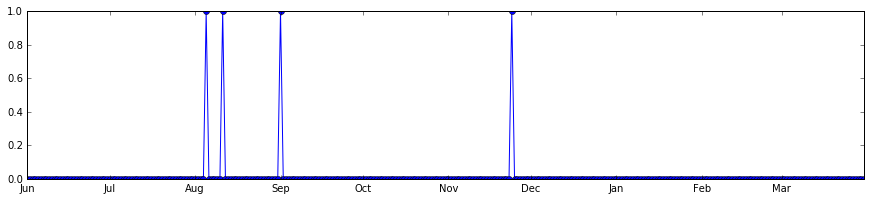




('Australia/SA/None', 'Other Government and Political Issues', 'General Population')
Counter({datetime.date(2015, 8, 15): 1, datetime.date(2015, 11, 23): 1, datetime.date(2015, 8, 9): 1, datetime.date(2015, 12, 9): 1, datetime.date(2015, 7, 25): 1})


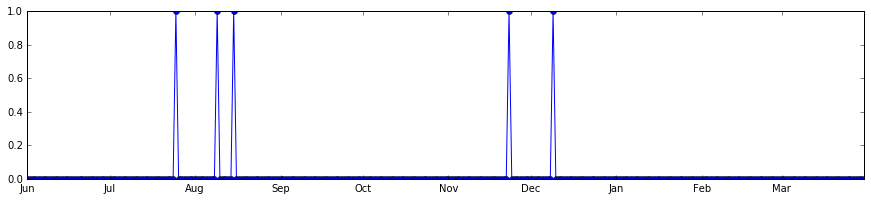

In [6]:
'''draw patterns on a daily basis'''

from collections import Counter
import datetime

# date string format "2016-01-01T00:00:00Z"
start = datetime.datetime.strptime(startTimeStr, "%Y-%m-%dT%H:%M:%SZ").date()
end = datetime.datetime.strptime(endTimeStr, "%Y-%m-%dT%H:%M:%SZ").date()

for tup in groupedList[:2]:
    print(tup[0])
    counter = Counter(tup[1])
    print(counter)
    cursor = start
    dateMap = dict()
    while cursor<=end:
        cnt = counter.get(cursor, 0)
        dateMap[cursor] = cnt
        #print(cursor, cnt)
        cursor = cursor + datetime.timedelta(days=1)
    #plot_bargraph(dateMap)
    plot_pattern_timeline(dateMap,'monthly', 'bo-')
    print("\n\n")
    #break


('Indonesia/West Java/Bandung', 'Employment and Wages', 'Labour')
Counter({datetime.date(2015, 8, 5): 1, datetime.date(2015, 8, 11): 1, datetime.date(2015, 11, 24): 1, datetime.date(2015, 9, 1): 1})


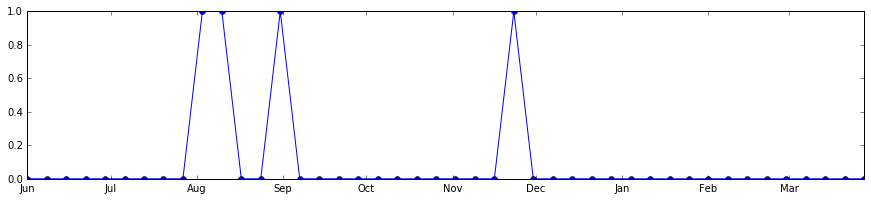




('Australia/SA/None', 'Other Government and Political Issues', 'General Population')
Counter({datetime.date(2015, 8, 15): 1, datetime.date(2015, 11, 23): 1, datetime.date(2015, 8, 9): 1, datetime.date(2015, 12, 9): 1, datetime.date(2015, 7, 25): 1})


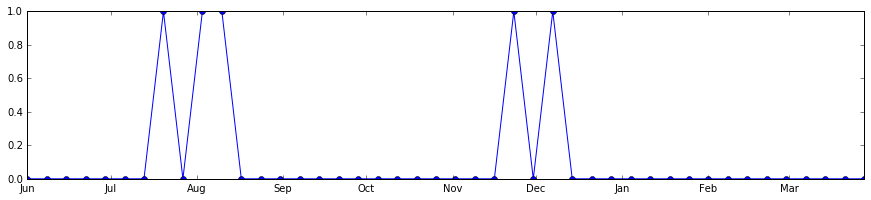

In [7]:
'''draw patterns on a weekly basis'''

from collections import Counter
import datetime

# date string format "2016-01-01T00:00:00Z"
start = datetime.datetime.strptime(startTimeStr, "%Y-%m-%dT%H:%M:%SZ").date()
end = datetime.datetime.strptime(endTimeStr, "%Y-%m-%dT%H:%M:%SZ").date()

for tup in groupedList[:2]:
    print(tup[0])
    counter = Counter(tup[1])
    print(counter)
    cursor = start
    dateMap = dict()
    while cursor<=end:
        _sum = 0
        for i in range(7):
            inner_cursor = cursor + datetime.timedelta(days=i)
            cnt = counter.get(inner_cursor, 0)
            _sum+=cnt
        dateMap[cursor] = _sum
        #print(cursor, _sum)
        cursor = cursor + datetime.timedelta(days=7)
    #plot_bargraph(dateMap)
    plot_pattern_timeline(dateMap, 'monthly', style='bo-')
    print("\n\n")
    #break

('Indonesia/West Java/Bandung', 'Employment and Wages', 'Labour')
Counter({datetime.date(2015, 9, 1): 1, datetime.date(2015, 8, 5): 1, datetime.date(2015, 11, 24): 1, datetime.date(2015, 8, 11): 1})
{datetime.date(2015, 12, 1): 0, datetime.date(2015, 10, 1): 0, datetime.date(2015, 9, 1): 1, datetime.date(2015, 11, 1): 1, datetime.date(2016, 3, 1): 0, datetime.date(2016, 2, 1): 0, datetime.date(2015, 7, 1): 0, datetime.date(2015, 6, 1): 0, datetime.date(2015, 8, 1): 2, datetime.date(2016, 1, 1): 0}


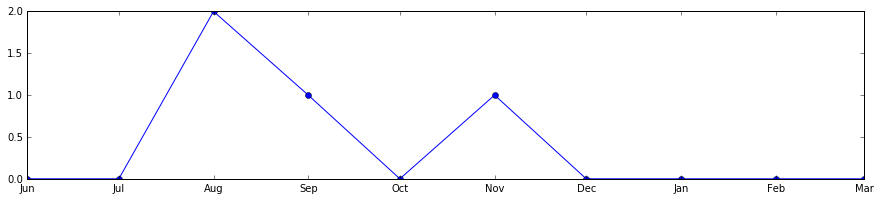




('Australia/SA/None', 'Other Government and Political Issues', 'General Population')
Counter({datetime.date(2015, 8, 15): 1, datetime.date(2015, 8, 9): 1, datetime.date(2015, 7, 25): 1, datetime.date(2015, 12, 9): 1, datetime.date(2015, 11, 23): 1})
{datetime.date(2015, 12, 1): 1, datetime.date(2015, 10, 1): 0, datetime.date(2015, 9, 1): 0, datetime.date(2015, 11, 1): 1, datetime.date(2016, 3, 1): 0, datetime.date(2016, 2, 1): 0, datetime.date(2015, 7, 1): 1, datetime.date(2015, 6, 1): 0, datetime.date(2015, 8, 1): 2, datetime.date(2016, 1, 1): 0}


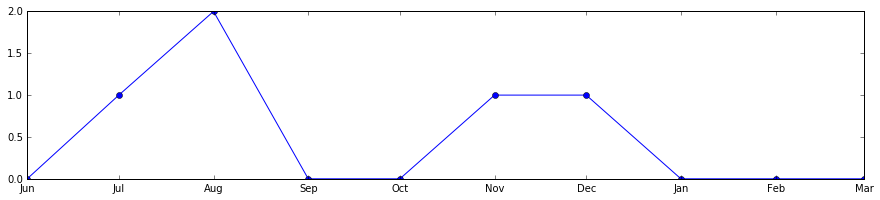

In [40]:
'''draw patterns on a monthly basis'''

from collections import Counter
import datetime

# date string format "2016-01-01T00:00:00Z"
start = datetime.datetime.strptime(startTimeStr, "%Y-%m-%dT%H:%M:%SZ").date()
end = datetime.datetime.strptime(endTimeStr, "%Y-%m-%dT%H:%M:%SZ").date()

for tup in groupedList[:2]:
    print(tup[0])
    counter = Counter(tup[1])
    print(counter)
    cursor = start
    dateMap = dict()
    while cursor<=end:
        _sum = 0
        for i in range(35):
            inner_cursor = cursor + datetime.timedelta(days=i)
            #print(i, inner_cursor, cursor)
            if inner_cursor.month!=cursor.month:
                #print("inside if", inner_cursor.month, cursor.month)
                dateMap[cursor] = _sum
                #print(cursor, _sum)
                cursor = inner_cursor
                #print("inside if cursor is updated to", cursor)
                break
            cnt = counter.get(inner_cursor, 0)
            _sum+=cnt
        #print(">>>", cursor, end)
        
    #plot_bargraph(dateMap)
    print(dateMap)
    plot_pattern_timeline(dateMap, 'monthly', 'bo-')
    print("\n\n")
    #break

instance no.:  3445
instance no. (grouped):  150 

('Indonesia/West Java/Bandung', 'Employment and Wages', 'Labour')
Counter({datetime.date(2015, 9, 1): 1, datetime.date(2015, 8, 5): 1, datetime.date(2015, 11, 24): 1, datetime.date(2015, 8, 11): 1})
{1: 0, 2: 3, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0}


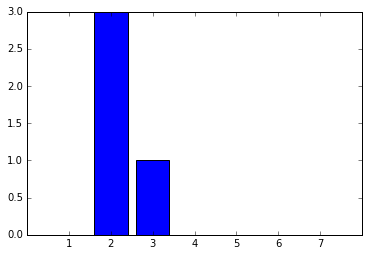




('Australia/SA/None', 'Other Government and Political Issues', 'General Population')
Counter({datetime.date(2015, 8, 15): 1, datetime.date(2015, 8, 9): 1, datetime.date(2015, 7, 25): 1, datetime.date(2015, 12, 9): 1, datetime.date(2015, 11, 23): 1})
{1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 2, 7: 1}


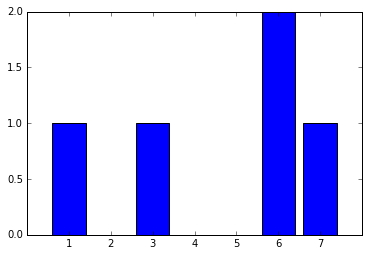




('Indonesia/Bali/Denpasar', 'Employment and Wages', 'labour')
Counter({datetime.date(2015, 11, 19): 2, datetime.date(2015, 12, 3): 1, datetime.date(2015, 11, 30): 1})
{1: 1, 2: 0, 3: 0, 4: 3, 5: 0, 6: 0, 7: 0}


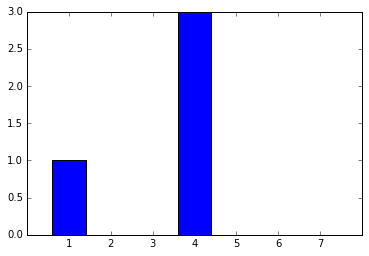




('Australia/NSW/None', 'Employment and Wages', 'Labor')
Counter({datetime.date(2015, 6, 18): 1, datetime.date(2015, 11, 12): 1, datetime.date(2015, 8, 7): 1, datetime.date(2015, 8, 6): 1, datetime.date(2015, 8, 3): 1, datetime.date(2015, 8, 23): 1, datetime.date(2015, 8, 10): 1, datetime.date(2015, 12, 11): 1})
{1: 2, 2: 0, 3: 0, 4: 3, 5: 2, 6: 0, 7: 1}


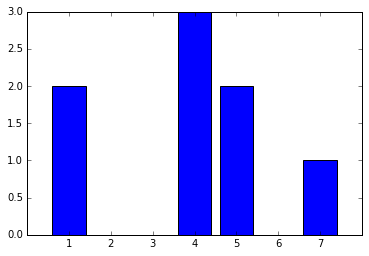




('Indonesia/Jakarta Raya/South Jakarta', 'Other Government and Political Issues', 'General Population')
Counter({datetime.date(2015, 11, 30): 2, datetime.date(2016, 1, 4): 1, datetime.date(2015, 12, 16): 1, datetime.date(2015, 8, 11): 1, datetime.date(2015, 12, 15): 1, datetime.date(2015, 10, 9): 1})
{1: 3, 2: 2, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0}


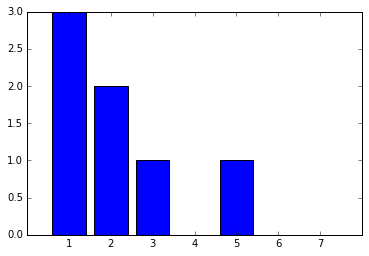




('Thailand/None/Nakhon Ratchasima', 'Other Social Disruption', 'General Population')
Counter({datetime.date(2015, 9, 7): 1, datetime.date(2015, 7, 9): 1, datetime.date(2015, 12, 11): 1, datetime.date(2015, 7, 20): 1, datetime.date(2015, 8, 31): 1})
{1: 3, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0, 7: 0}


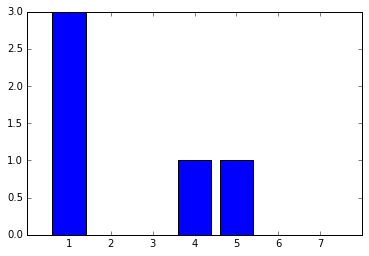




('Indonesia/Jakarta Raya/Central Jakarta', 'Other Government and Political Issues', 'General Population')
Counter({datetime.date(2016, 1, 18): 2, datetime.date(2015, 12, 10): 2, datetime.date(2016, 1, 21): 1, datetime.date(2015, 8, 20): 1, datetime.date(2015, 10, 5): 1, datetime.date(2015, 12, 3): 1, datetime.date(2015, 10, 20): 1, datetime.date(2015, 10, 23): 1})
{1: 3, 2: 1, 3: 0, 4: 5, 5: 1, 6: 0, 7: 0}


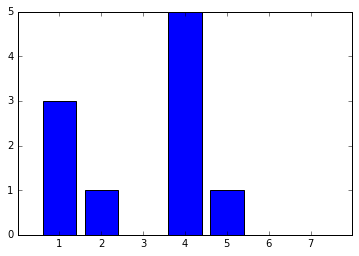




('Malaysia/Sarawak/Kuching', 'Other Social Disruption', 'General Population')
Counter({datetime.date(2015, 10, 10): 2, datetime.date(2015, 10, 11): 1, datetime.date(2015, 10, 4): 1, datetime.date(2015, 8, 31): 1, datetime.date(2015, 11, 1): 1, datetime.date(2015, 7, 22): 1, datetime.date(2015, 9, 27): 1, datetime.date(2015, 10, 3): 1})
{1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 3, 7: 4}


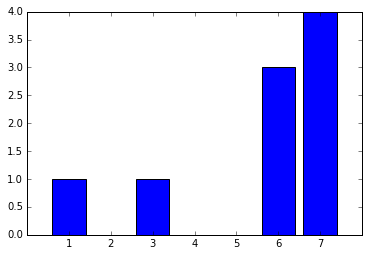




('Thailand/None/Bangkok', 'Other Social Disruption', 'Religious')
Counter({datetime.date(2015, 11, 27): 1, datetime.date(2015, 7, 10): 1, datetime.date(2015, 9, 9): 1, datetime.date(2015, 7, 21): 1, datetime.date(2015, 10, 7): 1})
{1: 0, 2: 1, 3: 2, 4: 0, 5: 2, 6: 0, 7: 0}


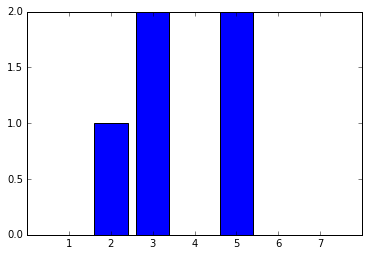




('Indonesia/Aceh/Banda Aceh', 'Other Social Disruption', 'General Population')
Counter({datetime.date(2016, 2, 14): 1, datetime.date(2015, 11, 6): 1, datetime.date(2015, 9, 18): 1, datetime.date(2016, 2, 19): 1})
{1: 0, 2: 0, 3: 0, 4: 0, 5: 3, 6: 0, 7: 1}


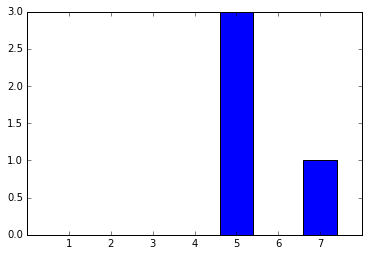

In [12]:
'''draw histogram patterns by weekdays'''


mappedDf = gsrDf.rdd.map(lambda row : ((str(row.country)+'/'+str(row.state)+'/'+str(row.city), row.eventType, row.populationGroup), ((row.asDict()['key:eventDate'].date()))))
#mappedDf = gsrDf.rdd.map(lambda row : ((str(row.country)+'/'+str(row.state)+'/'+str(row.city)), ((row.asDict()['key:eventDate'].date()))))
print('instance no.: ', mappedDf.count())
#mappedDf.take(5)

groupedDf = mappedDf.aggregateByKey(list(), lambda lst,val: lst+[val], lambda lst1,lst2: lst1+lst2).filter(lambda x: len(x[1])>=4)
print('instance no. (grouped): ', groupedDf.count(), '\n')
groupedList = groupedDf.collect()
#groupedList[0:3]


from collections import Counter
import datetime
# date string format "2016-01-01T00:00:00Z"
start = datetime.datetime.strptime(startTimeStr, "%Y-%m-%dT%H:%M:%SZ").date()
end = datetime.datetime.strptime(endTimeStr, "%Y-%m-%dT%H:%M:%SZ").date()

for tup in groupedList[:10]:
    print(tup[0])
    counter = Counter(tup[1])
    print(counter)
    cursor = start
    dateMap = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0} #0 is Monday, 1 is Tuesday, 2 is Wednesday, ...
    #dateMap = {'Mon':0, 'Tue':0, 'Wed':0, 'Thu':0, 'Fri':0, 'Sat':0, 'Sun':0}
    #dateIndex = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
    while cursor<=end:
        day = cursor.weekday()
        #dayStr = dateIndex[day]
        cnt = counter.get(cursor, 0)
        #dateMap[dayStr] += cnt
        dateMap[day] += cnt
        #print(cursor, _sum)
        cursor += datetime.timedelta(days=1)
    #print(dateMap)
    dateMapReadable = {}
    for key in dateMap:
        dateMapReadable[key+1] = dateMap[key]#rewrite the index of Monday to 1, that of Tuesday to 2, ...
    print(dateMapReadable)
    plot_bargraph(dateMapReadable, 'horizontal')
    #plot_pattern_timeline(dateMapReadable)
    print("\n\n")
    #break

In [47]:
'''draw patterns on a daily basis.
same location and event type, different populaton groups'''




mappedDf = gsrDf.rdd.map(lambda row : ((str(row.country)+'/'+str(row.state)+'/'+str(row.city), row.eventType, row.populationGroup), ((row.asDict()['key:eventDate'].date()))))
#mappedDf = gsrDf.rdd.map(lambda row : ((str(row.country)+'/'+str(row.state)+'/'+str(row.city)), ((row.asDict()['key:eventDate'].date()))))
print('instance no.: ', mappedDf.count())
#mappedDf.take(5)

groupedDf = mappedDf.aggregateByKey(list(), lambda lst,val: lst+[val], lambda lst1,lst2: lst1+lst2).filter(lambda x: len(x[1])>=4)
print('instance no. (grouped): ', groupedDf.count(), '\n')
groupedList = groupedDf.collect()
groupedList




instance no.:  3445
instance no. (grouped):  150 



[(('Indonesia/West Java/Bandung', 'Employment and Wages', 'Labour'),
  [datetime.date(2015, 11, 24),
   datetime.date(2015, 9, 1),
   datetime.date(2015, 8, 5),
   datetime.date(2015, 8, 11)]),
 (('Thailand/None/Nakhon Ratchasima',
   'Other Social Disruption',
   'General Population'),
  [datetime.date(2015, 7, 9),
   datetime.date(2015, 9, 7),
   datetime.date(2015, 12, 11),
   datetime.date(2015, 8, 31),
   datetime.date(2015, 7, 20)]),
 (('Australia/SA/None',
   'Other Government and Political Issues',
   'General Population'),
  [datetime.date(2015, 8, 15),
   datetime.date(2015, 8, 9),
   datetime.date(2015, 11, 23),
   datetime.date(2015, 12, 9),
   datetime.date(2015, 7, 25)]),
 (('Indonesia/Bali/Denpasar', 'Employment and Wages', 'labour'),
  [datetime.date(2015, 11, 30),
   datetime.date(2015, 11, 19),
   datetime.date(2015, 12, 3),
   datetime.date(2015, 11, 19)]),
 (('Australia/NSW/None', 'Employment and Wages', 'Labor'),
  [datetime.date(2015, 8, 3),
   datetime.date(2015,

# of instances: 118 

dualKey =  ('Indonesia/Jakarta Raya/Jakarta', 'Other Social Disruption')
groups:
	 Religious
	 General
	 General Population
	 Education
Religious in blue, Education in red, General Population in green, General in cyan


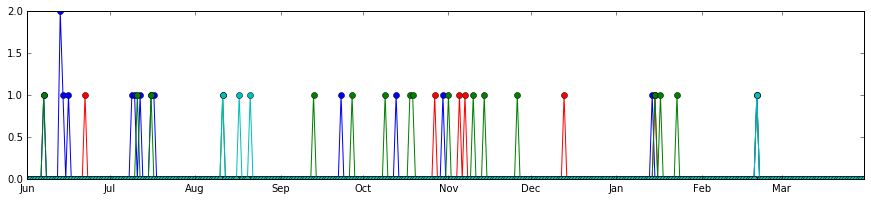




dualKey =  ('Indonesia/Riau/Pekan Baru', 'Land, Energy, and Resources')
groups:
	 education
	 Education
education in blue, Education in red


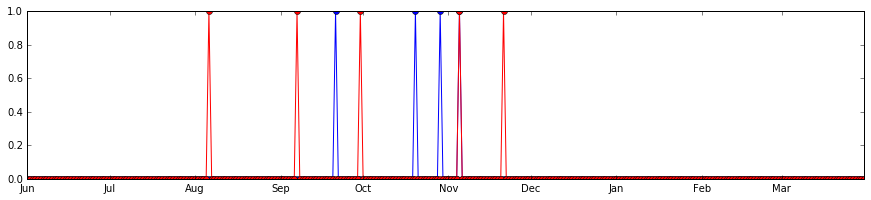




dualKey =  ('Indonesia/Daerah Istimewa Yogyakarta/Yogyakarta', 'Other Social Disruption')
groups:
	 General
	 General Population
General in blue, General Population in red


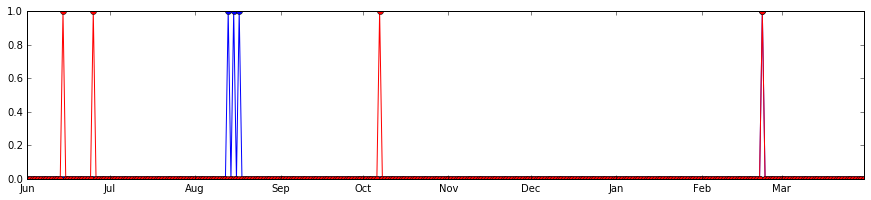




dualKey =  ('Australia/VIC/Melbourne', 'Other Government and Political Issues')
groups:
	 Medical
	 General Population
	 General
Medical in blue, General Population in red, General in green


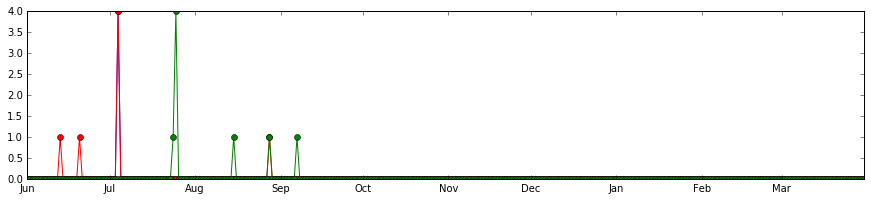




dualKey =  ('Indonesia/Jakarta Raya/Jakarta', 'Employment and Wages')
groups:
	 Business
	 Labour
Business in blue, Labour in red


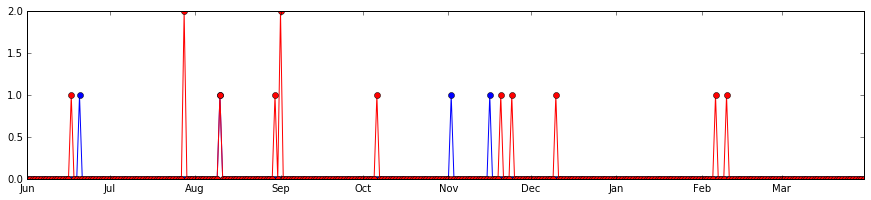




dualKey =  ('Indonesia/West Java/Bandung', 'Other Social Disruption')
groups:
	 Religious
	 General Population
Religious in blue, General Population in red


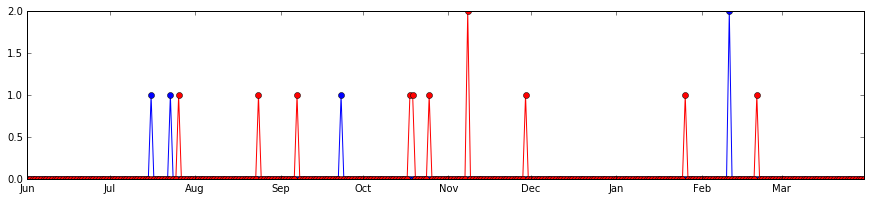




dualKey =  ('Indonesia/Jakarta Raya/Jakarta', 'Other Government and Political Issues')
groups:
	 General
	 Labour
	 Education
	 General Population
	 Business
Business in blue, General in red, Labour in green, General Population in cyan, Education in magenta


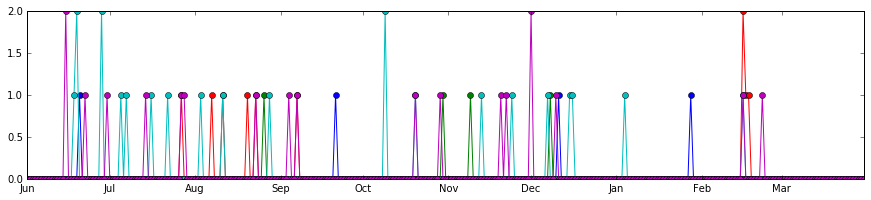




dualKey =  ('Indonesia/Riau/Pekan Baru', 'Other Government and Political Issues')
groups:
	 education
	 General Population
education in blue, General Population in red


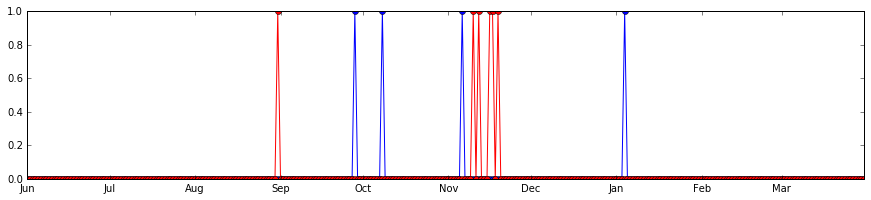




dualKey =  ('Thailand/None/Ubon Ratchathani', 'Other Social Disruption')
groups:
	 General Population
	 Education
General Population in blue, Education in red


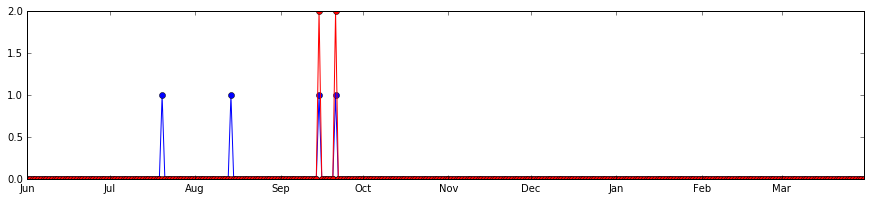




dualKey =  ('Thailand/None/Bangkok', 'Other Social Disruption')
groups:
	 Religious
	 General Population
Religious in blue, General Population in red


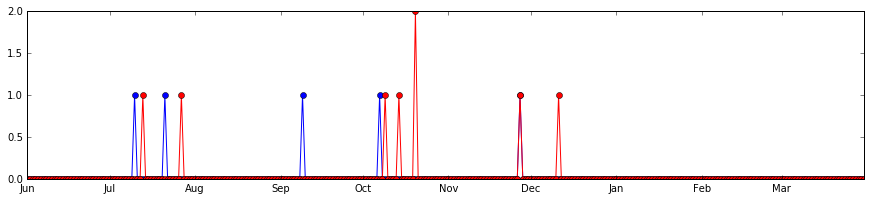




dualKey =  ('Australia/Queensland/Brisbane', 'Employment and Wages')
groups:
	 Labor
	 Labour
Labor in blue, Labour in red


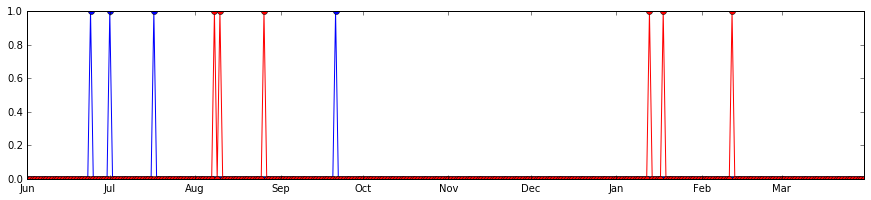




dualKey =  ('Australia/NSW/Sydney', 'Other Government and Political Issues')
groups:
	 General
	 General Population
General in blue, General Population in red


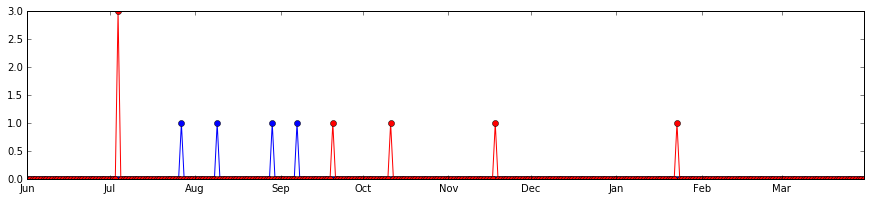




dualKey =  ('Fiji/Central/Suva', 'Other Social Disruption')
groups:
	 General Population
	 Education
General Population in blue, Education in red


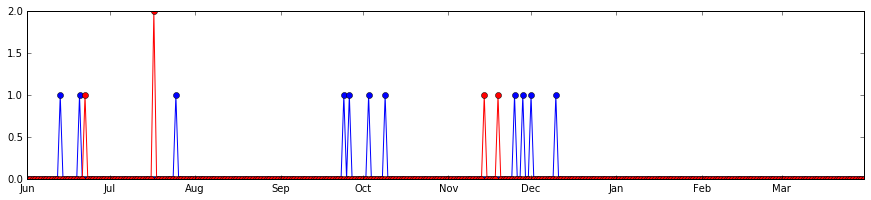




dualKey =  ('Malaysia/Kuala Lumpur/Kuala Lumpur', 'Other Social Disruption')
groups:
	 Religious
	 General Population
Religious in blue, General Population in red


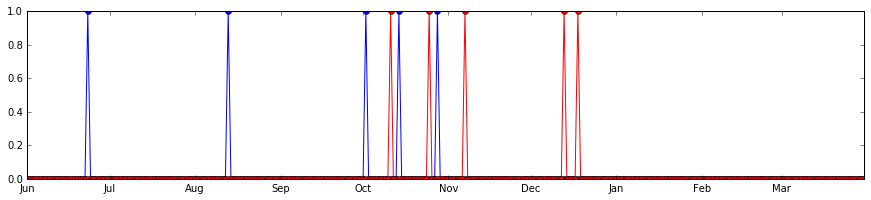




dualKey =  ('Australia/SA/Adelaide', 'Other Social Disruption')
groups:
	 Labor
	 General Population
Labor in blue, General Population in red


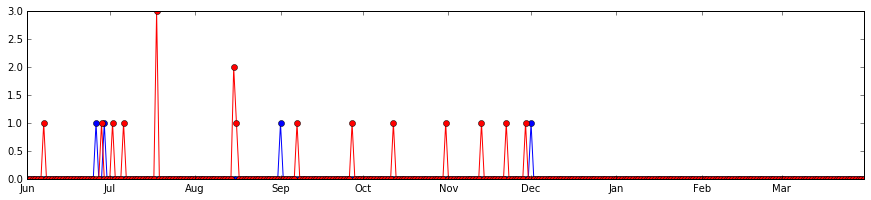




dualKey =  ('Australia/VIC/Melbourne', 'Employment and Wages')
groups:
	 Labor
	 Labour
Labor in blue, Labour in red


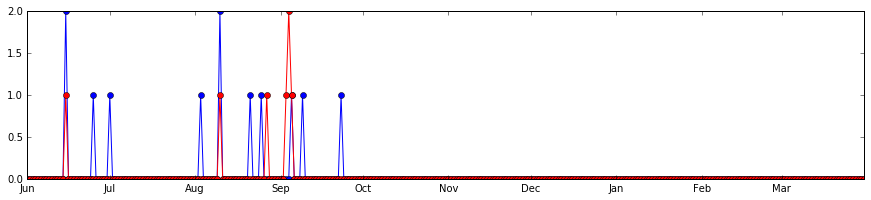




dualKey =  ('Indonesia/West Java/Bogor', 'Employment and Wages')
groups:
	 labour
	 Labour
labour in blue, Labour in red


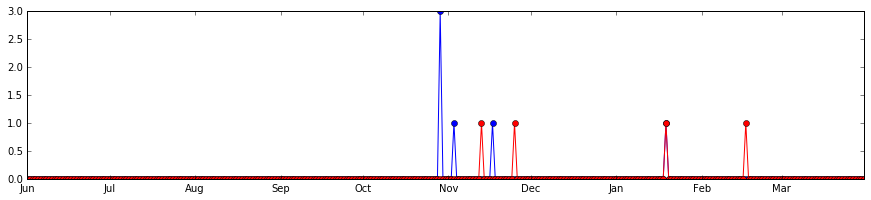




dualKey =  ('Indonesia/West Java/Bandung', 'Other Government and Political Issues')
groups:
	 General Population
	 Education
General Population in blue, Education in red


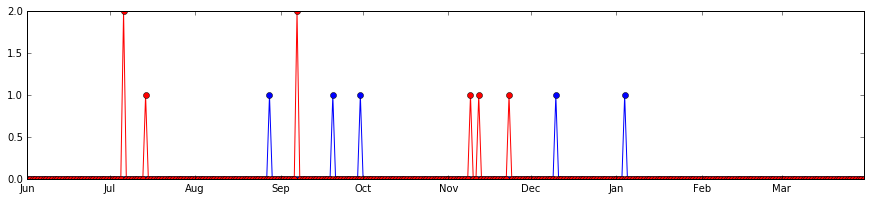




dualKey =  ('Australia/NSW/Sydney', 'Employment and Wages')
groups:
	 Labor
	 Labour
Labor in blue, Labour in red


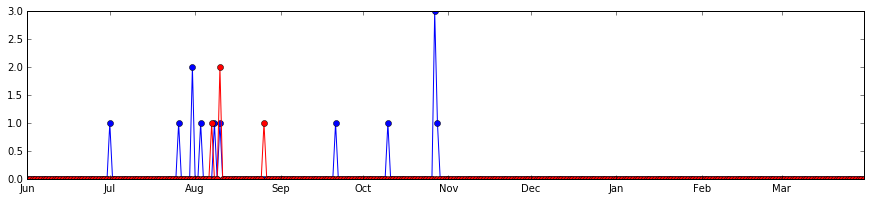




dualKey =  ('Indonesia/Jakarta Raya/Central Jakarta', 'Other Government and Political Issues')
groups:
	 education
	 General Population
education in blue, General Population in red


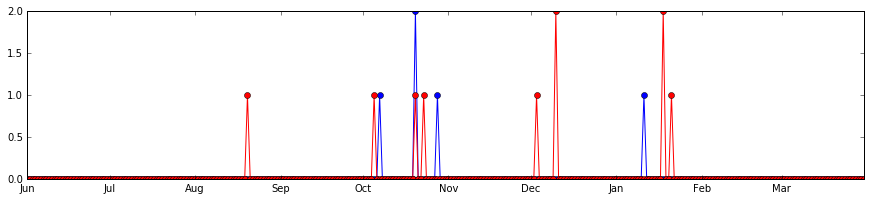




dualKey =  ('Thailand/None/Bangkok', 'Other Government and Political Issues')
groups:
	 Labor
	 General Population
	 Education
Labor in blue, General Population in red, Education in green


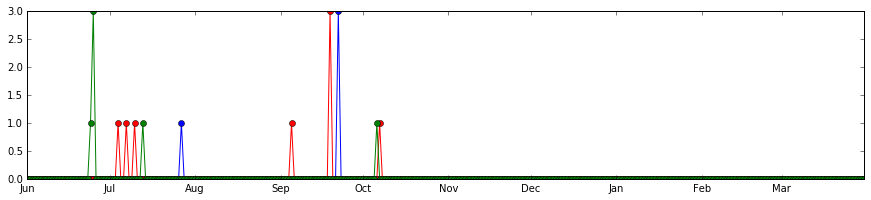




dualKey =  ('Australia/VIC/Melbourne', 'Other Social Disruption')
groups:
	 Labor
	 General Population
Labor in blue, General Population in red


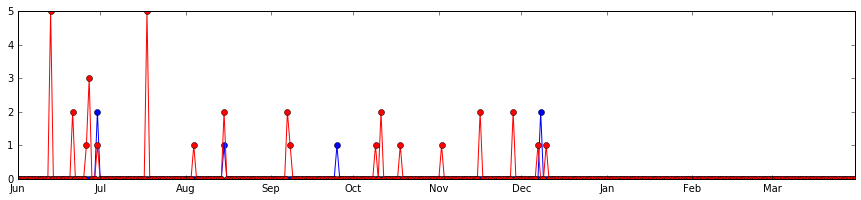




dualKey =  ('Indonesia/East Java/Surabaya', 'Employment and Wages')
groups:
	 labour
	 Labour
labour in blue, Labour in red


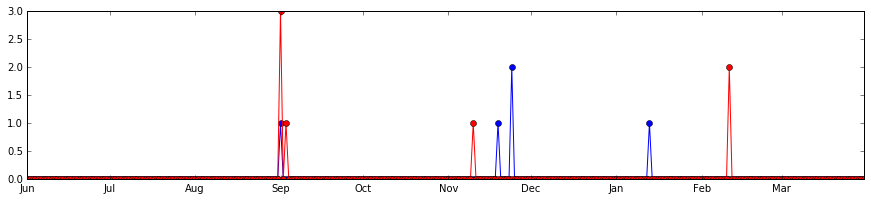




dualKey =  ('Indonesia/West Java/Bandung', 'Employment and Wages')
groups:
	 Labour
	 labour
Labour in blue, labour in red


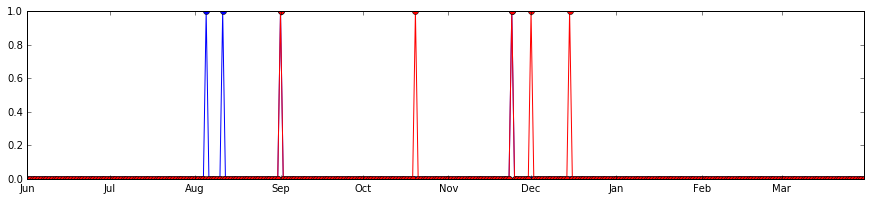




dualKey =  ('Australia/SA/Adelaide', 'Other Government and Political Issues')
groups:
	 General
	 General Population
General in blue, General Population in red


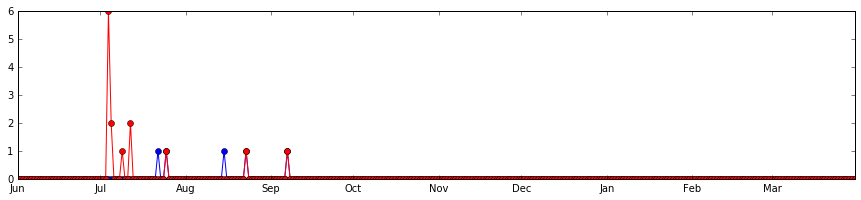

In [111]:
outMap = dict()
for tup in groupedList:
    key = (tup[0][0],tup[0][1])
    inMap = outMap.get(key, dict())
    #print('inMap_old=', inMap)
    inMap[tup[0][2]] = tup[1]
    outMap[key] = inMap
    #print('key = ', key, '\nvalue = ', outMap[key])
    #for k in outMap[key]:
    #    print('--->', k)
    #print('\n')

from collections import Counter
import datetime
# date string format "2016-01-01T00:00:00Z"
start = datetime.datetime.strptime(startTimeStr, "%Y-%m-%dT%H:%M:%SZ").date()
end = datetime.datetime.strptime(endTimeStr, "%Y-%m-%dT%H:%M:%SZ").date()

print('# of instances:', len(outMap), '\n')

for dualKey in outMap:
    inMap = outMap[dualKey]
    if len(inMap)<2: # num of different pop groups
        continue
    print('dualKey = ', dualKey)
    print('groups:')
    popDatesMap = dict()
    for pop in inMap:
        counter = Counter(inMap[pop])
        print('\t',pop)
        #print(counter)
        cursor = start
        dateMap = dict()
        while cursor<=end:
            cnt = counter.get(cursor, 0)
            dateMap[cursor] = cnt
            #print(cursor, cnt)
            cursor = cursor + datetime.timedelta(days=1)
        popDatesMap[pop]=dateMap
    plot_pattern_timeline_multilines(popDatesMap,'monthly')
    print("\n\n")
    #break


